In [2]:
import torch.nn as nn
import torch
import os
import sys
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.optim as optim
import copy
from sklearn.model_selection import KFold

sys.path.append('../')
from utils import BrainGraphDataset, get_data_labels, project_root
from old_models import SimpleFCNN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# set the random seed for reproducibility
torch.manual_seed(0)

# define the hyperparameters
input_dim = 4950
hidden_dim = 128

lr = 1e-3
batch_size = 8
num_epochs = 200

annotations = 'annotations.csv'

parent_dir = project_root()
dataroot = 'fc_matrices/psilo_ica_100_before/'
categories = ['patient_n','condition','bdi_before']

data_labels = get_data_labels()
data_labels = data_labels[categories]

data_labels.loc[data_labels["condition"] == "P", "condition"] = 1
data_labels.loc[data_labels["condition"] == "E", "condition"] = -1
data_labels['condition'] = data_labels['condition'].astype('float64')

dataset = BrainGraphDataset(img_dir=os.path.join(parent_dir, dataroot),
                            annotations_file= os.path.join(parent_dir, annotations),
                            transform=None, extra_data=data_labels, setting='upper_triangular_and_baseline')

# split the dataset into training and validation sets

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Create empty lists to store train and validation loaders
train_loaders = []
val_loaders = []
train_sizes = []
val_sizes = []

torch.manual_seed(0)
for train_index, val_index in kf.split(dataset):
    # Split dataset into train and validation sets for the current fold
    train_set = torch.utils.data.Subset(dataset, train_index)
    val_set = torch.utils.data.Subset(dataset, val_index)

    # Define the dataloaders for the current fold
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    # Append the loaders to the respective lists
    train_loaders.append(train_loader)
    val_loaders.append(val_loader)
    train_sizes.append(len(train_set))
    val_sizes.append(len(val_set))

# define a dictionary to store the loss curves for each configuration
loss_curves = {}
dropout_list = [0]

for dropout in dropout_list:
    best_set = [None] * num_folds 
    for t, t_loader in enumerate(train_loaders):
        val_loader = val_loaders[t]
        best_val_loss = float('inf')  # set to infinity to start
        best_model_state = None

        train_losses = []
        val_losses = []
        hidden = [32] * 4
        model = SimpleFCNN(2, hidden, dropout=dropout)
        model = model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)

        for epoch in tqdm(range(num_epochs)):
            train_loss = 0.0
            val_loss = 0.0

            # training
            model.train()
            for batch_idx, ((_, base), label) in enumerate(t_loader):
                base = base.to(device)
                label = label.to(device)
                
                optimizer.zero_grad()

                output = model(base, base)

                (mae_loss, l2_reg) = model.loss(output, label.view(output.shape))
                loss = mae_loss + l2_reg
                loss.backward()
                optimizer.step()
                train_loss += mae_loss.item()

            # validation
            model.eval()
            val_label = []
            val_output = []
            val_base = []
            with torch.no_grad():
                for batch_idx, ((_, base), label) in enumerate(val_loader):
                    base = base.to(device)
                    label = label.to(device)

                    output = model(base, base)
                    
                    val_label.extend(label)
                    val_output.extend(output)
                    val_base.extend(base)
                    
                    (mae_loss, l2_reg) = model.loss(output, label.view(output.shape))
                    loss = mae_loss + l2_reg
                    val_loss += mae_loss.item()
            # append losses to lists
            train_losses.append(train_loss/(train_sizes[t]))
            val_losses.append(val_loss/(val_sizes[t]))

            # save the model if the validation loss is at its minimum
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = (copy.deepcopy(model.state_dict()), epoch)
                best_set[t] = (val_label, val_output, val_base)

            if (epoch + 1) % 10 == 0:
                print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_losses[-1]:.4f}\n')



cpu


  5%|▌         | 10/200 [00:14<04:40,  1.47s/it]

Epoch 10/200 - Train Loss: 6.5320 - Val Loss: 11.1482



 10%|█         | 20/200 [00:29<04:21,  1.45s/it]

Epoch 20/200 - Train Loss: 6.3068 - Val Loss: 10.8742



 15%|█▌        | 30/200 [00:43<04:12,  1.48s/it]

Epoch 30/200 - Train Loss: 6.2769 - Val Loss: 10.8262



 20%|██        | 40/200 [00:58<03:55,  1.47s/it]

Epoch 40/200 - Train Loss: 6.2697 - Val Loss: 10.7782



 25%|██▌       | 50/200 [01:13<03:41,  1.48s/it]

Epoch 50/200 - Train Loss: 6.2215 - Val Loss: 10.7536



 30%|███       | 60/200 [01:28<03:26,  1.47s/it]

Epoch 60/200 - Train Loss: 6.2112 - Val Loss: 10.7349



 35%|███▌      | 70/200 [01:42<03:10,  1.47s/it]

Epoch 70/200 - Train Loss: 6.2071 - Val Loss: 10.7345



 40%|████      | 80/200 [01:57<02:55,  1.47s/it]

Epoch 80/200 - Train Loss: 6.1792 - Val Loss: 10.7494



 45%|████▌     | 90/200 [02:12<02:40,  1.46s/it]

Epoch 90/200 - Train Loss: 6.1436 - Val Loss: 10.6868



 50%|█████     | 100/200 [02:27<02:27,  1.47s/it]

Epoch 100/200 - Train Loss: 6.1419 - Val Loss: 10.7032



 55%|█████▌    | 110/200 [02:41<02:11,  1.47s/it]

Epoch 110/200 - Train Loss: 6.0827 - Val Loss: 10.6775



 60%|██████    | 120/200 [02:56<01:57,  1.47s/it]

Epoch 120/200 - Train Loss: 6.0868 - Val Loss: 10.6607



 65%|██████▌   | 130/200 [03:11<01:42,  1.46s/it]

Epoch 130/200 - Train Loss: 6.0212 - Val Loss: 10.6479



 70%|███████   | 140/200 [03:45<02:32,  2.54s/it]

Epoch 140/200 - Train Loss: 5.9833 - Val Loss: 10.5749



 75%|███████▌  | 150/200 [04:00<01:15,  1.51s/it]

Epoch 150/200 - Train Loss: 5.9759 - Val Loss: 10.5174



 80%|████████  | 160/200 [04:15<00:58,  1.46s/it]

Epoch 160/200 - Train Loss: 5.9315 - Val Loss: 10.5206



 85%|████████▌ | 170/200 [04:29<00:44,  1.47s/it]

Epoch 170/200 - Train Loss: 5.9274 - Val Loss: 10.5512



 90%|█████████ | 180/200 [04:44<00:29,  1.46s/it]

Epoch 180/200 - Train Loss: 5.8951 - Val Loss: 10.4985



 95%|█████████▌| 190/200 [04:59<00:14,  1.45s/it]

Epoch 190/200 - Train Loss: 5.8821 - Val Loss: 10.4908



100%|██████████| 200/200 [05:13<00:00,  1.57s/it]


Epoch 200/200 - Train Loss: 5.8667 - Val Loss: 10.4402



  5%|▌         | 10/200 [00:14<04:31,  1.43s/it]

Epoch 10/200 - Train Loss: 7.6434 - Val Loss: 6.5743



 10%|█         | 20/200 [00:28<04:19,  1.44s/it]

Epoch 20/200 - Train Loss: 7.4216 - Val Loss: 6.5686



 15%|█▌        | 30/200 [00:43<04:06,  1.45s/it]

Epoch 30/200 - Train Loss: 7.3837 - Val Loss: 6.5441



 20%|██        | 40/200 [00:57<03:50,  1.44s/it]

Epoch 40/200 - Train Loss: 7.3671 - Val Loss: 6.5268



 25%|██▌       | 50/200 [01:11<03:33,  1.42s/it]

Epoch 50/200 - Train Loss: 7.3152 - Val Loss: 6.5034



 30%|███       | 60/200 [01:26<03:19,  1.43s/it]

Epoch 60/200 - Train Loss: 7.2874 - Val Loss: 6.4851



 35%|███▌      | 70/200 [01:40<03:05,  1.42s/it]

Epoch 70/200 - Train Loss: 7.2616 - Val Loss: 6.4617



 40%|████      | 80/200 [01:54<02:54,  1.45s/it]

Epoch 80/200 - Train Loss: 7.2414 - Val Loss: 6.4507



 45%|████▌     | 90/200 [02:09<02:37,  1.43s/it]

Epoch 90/200 - Train Loss: 7.1955 - Val Loss: 6.4192



 50%|█████     | 100/200 [02:23<02:23,  1.43s/it]

Epoch 100/200 - Train Loss: 7.1667 - Val Loss: 6.3901



 55%|█████▌    | 110/200 [02:37<02:09,  1.44s/it]

Epoch 110/200 - Train Loss: 7.1308 - Val Loss: 6.3718



 60%|██████    | 120/200 [02:52<01:54,  1.43s/it]

Epoch 120/200 - Train Loss: 7.0924 - Val Loss: 6.3357



 65%|██████▌   | 130/200 [03:06<01:39,  1.42s/it]

Epoch 130/200 - Train Loss: 7.0512 - Val Loss: 6.2955



 70%|███████   | 140/200 [03:20<01:25,  1.42s/it]

Epoch 140/200 - Train Loss: 7.0307 - Val Loss: 6.2663



 75%|███████▌  | 150/200 [03:35<01:12,  1.44s/it]

Epoch 150/200 - Train Loss: 6.9845 - Val Loss: 6.2295



 80%|████████  | 160/200 [03:49<00:57,  1.44s/it]

Epoch 160/200 - Train Loss: 6.9695 - Val Loss: 6.2067



 85%|████████▌ | 170/200 [04:04<00:43,  1.45s/it]

Epoch 170/200 - Train Loss: 6.9556 - Val Loss: 6.2398



 90%|█████████ | 180/200 [04:18<00:28,  1.43s/it]

Epoch 180/200 - Train Loss: 6.9260 - Val Loss: 6.1884



 95%|█████████▌| 190/200 [04:32<00:14,  1.43s/it]

Epoch 190/200 - Train Loss: 6.9285 - Val Loss: 6.1165



100%|██████████| 200/200 [04:46<00:00,  1.43s/it]


Epoch 200/200 - Train Loss: 6.9513 - Val Loss: 6.2947



  5%|▌         | 10/200 [00:14<04:35,  1.45s/it]

Epoch 10/200 - Train Loss: 7.4715 - Val Loss: 6.5276



 10%|█         | 20/200 [00:28<04:20,  1.45s/it]

Epoch 20/200 - Train Loss: 7.4239 - Val Loss: 6.4701



 15%|█▌        | 30/200 [00:43<04:03,  1.43s/it]

Epoch 30/200 - Train Loss: 7.3718 - Val Loss: 6.4311



 20%|██        | 40/200 [00:57<03:49,  1.44s/it]

Epoch 40/200 - Train Loss: 7.3414 - Val Loss: 6.3958



 25%|██▌       | 50/200 [01:12<03:36,  1.44s/it]

Epoch 50/200 - Train Loss: 7.3370 - Val Loss: 6.3675



 30%|███       | 60/200 [01:26<03:22,  1.45s/it]

Epoch 60/200 - Train Loss: 7.3170 - Val Loss: 6.3375



 35%|███▌      | 70/200 [01:43<04:07,  1.91s/it]

Epoch 70/200 - Train Loss: 7.3133 - Val Loss: 6.3090



 40%|████      | 80/200 [01:58<02:53,  1.45s/it]

Epoch 80/200 - Train Loss: 7.2623 - Val Loss: 6.2887



 45%|████▌     | 90/200 [02:12<02:37,  1.43s/it]

Epoch 90/200 - Train Loss: 7.2485 - Val Loss: 6.2652



 50%|█████     | 100/200 [02:26<02:23,  1.43s/it]

Epoch 100/200 - Train Loss: 7.2316 - Val Loss: 6.2464



 55%|█████▌    | 110/200 [02:41<02:15,  1.50s/it]

Epoch 110/200 - Train Loss: 7.2352 - Val Loss: 6.2251



 60%|██████    | 120/200 [02:57<01:56,  1.46s/it]

Epoch 120/200 - Train Loss: 7.2053 - Val Loss: 6.2060



 65%|██████▌   | 130/200 [03:11<01:42,  1.46s/it]

Epoch 130/200 - Train Loss: 7.2061 - Val Loss: 6.1884



 70%|███████   | 140/200 [03:26<01:26,  1.45s/it]

Epoch 140/200 - Train Loss: 7.1805 - Val Loss: 6.1689



 75%|███████▌  | 150/200 [03:40<01:12,  1.45s/it]

Epoch 150/200 - Train Loss: 7.1719 - Val Loss: 6.1482



 80%|████████  | 160/200 [03:55<00:57,  1.45s/it]

Epoch 160/200 - Train Loss: 7.1639 - Val Loss: 6.1263



 85%|████████▌ | 170/200 [04:09<00:42,  1.43s/it]

Epoch 170/200 - Train Loss: 7.1399 - Val Loss: 6.1012



 90%|█████████ | 180/200 [04:23<00:28,  1.43s/it]

Epoch 180/200 - Train Loss: 7.1263 - Val Loss: 6.0787



 95%|█████████▌| 190/200 [04:38<00:14,  1.44s/it]

Epoch 190/200 - Train Loss: 7.1103 - Val Loss: 6.0507



100%|██████████| 200/200 [04:52<00:00,  1.46s/it]


Epoch 200/200 - Train Loss: 7.0880 - Val Loss: 6.0218



  5%|▌         | 10/200 [00:14<04:38,  1.47s/it]

Epoch 10/200 - Train Loss: 7.9130 - Val Loss: 6.4747



 10%|█         | 20/200 [00:29<04:21,  1.45s/it]

Epoch 20/200 - Train Loss: 7.6120 - Val Loss: 5.6635



 15%|█▌        | 30/200 [00:43<04:06,  1.45s/it]

Epoch 30/200 - Train Loss: 7.5549 - Val Loss: 5.6421



 20%|██        | 40/200 [00:58<03:55,  1.47s/it]

Epoch 40/200 - Train Loss: 7.4910 - Val Loss: 5.6051



 25%|██▌       | 50/200 [01:13<03:38,  1.46s/it]

Epoch 50/200 - Train Loss: 7.4636 - Val Loss: 5.6008



 30%|███       | 60/200 [01:27<03:23,  1.45s/it]

Epoch 60/200 - Train Loss: 7.4122 - Val Loss: 5.5754



 35%|███▌      | 70/200 [01:42<03:09,  1.46s/it]

Epoch 70/200 - Train Loss: 7.3538 - Val Loss: 5.6033



 40%|████      | 80/200 [01:56<02:54,  1.45s/it]

Epoch 80/200 - Train Loss: 7.3630 - Val Loss: 5.6492



 45%|████▌     | 90/200 [02:11<02:38,  1.44s/it]

Epoch 90/200 - Train Loss: 7.2853 - Val Loss: 5.5058



 50%|█████     | 100/200 [02:25<02:21,  1.41s/it]

Epoch 100/200 - Train Loss: 7.2061 - Val Loss: 5.6546



 55%|█████▌    | 110/200 [02:39<02:07,  1.41s/it]

Epoch 110/200 - Train Loss: 7.1129 - Val Loss: 5.5560



 60%|██████    | 120/200 [02:53<01:54,  1.43s/it]

Epoch 120/200 - Train Loss: 7.0099 - Val Loss: 5.7006



 65%|██████▌   | 130/200 [03:08<01:41,  1.45s/it]

Epoch 130/200 - Train Loss: 6.8778 - Val Loss: 5.7866



 70%|███████   | 140/200 [03:22<01:27,  1.45s/it]

Epoch 140/200 - Train Loss: 6.7825 - Val Loss: 5.8914



 75%|███████▌  | 150/200 [03:37<01:12,  1.45s/it]

Epoch 150/200 - Train Loss: 6.7004 - Val Loss: 6.0243



 80%|████████  | 160/200 [03:51<00:58,  1.46s/it]

Epoch 160/200 - Train Loss: 6.6740 - Val Loss: 6.0729



 85%|████████▌ | 170/200 [04:06<00:43,  1.44s/it]

Epoch 170/200 - Train Loss: 6.5928 - Val Loss: 6.4248



 90%|█████████ | 180/200 [04:20<00:28,  1.43s/it]

Epoch 180/200 - Train Loss: 6.6790 - Val Loss: 5.8868



 95%|█████████▌| 190/200 [04:34<00:14,  1.43s/it]

Epoch 190/200 - Train Loss: 6.5806 - Val Loss: 6.3736



100%|██████████| 200/200 [04:49<00:00,  1.45s/it]


Epoch 200/200 - Train Loss: 6.5670 - Val Loss: 6.1928



  5%|▌         | 10/200 [00:14<04:35,  1.45s/it]

Epoch 10/200 - Train Loss: 7.4915 - Val Loss: 6.2751



 10%|█         | 20/200 [00:28<04:18,  1.44s/it]

Epoch 20/200 - Train Loss: 7.4462 - Val Loss: 6.2279



 15%|█▌        | 30/200 [00:43<04:08,  1.46s/it]

Epoch 30/200 - Train Loss: 7.4534 - Val Loss: 6.1747



 20%|██        | 40/200 [00:57<03:53,  1.46s/it]

Epoch 40/200 - Train Loss: 7.3872 - Val Loss: 6.1846



 25%|██▌       | 50/200 [01:12<03:39,  1.46s/it]

Epoch 50/200 - Train Loss: 7.3564 - Val Loss: 6.0945



 30%|███       | 60/200 [01:27<03:25,  1.47s/it]

Epoch 60/200 - Train Loss: 7.3233 - Val Loss: 6.0545



 35%|███▌      | 70/200 [01:42<03:16,  1.51s/it]

Epoch 70/200 - Train Loss: 7.3027 - Val Loss: 6.0184



 40%|████      | 80/200 [01:57<03:06,  1.55s/it]

Epoch 80/200 - Train Loss: 7.2954 - Val Loss: 5.9857



 45%|████▌     | 90/200 [02:12<02:40,  1.46s/it]

Epoch 90/200 - Train Loss: 7.2507 - Val Loss: 5.9433



 50%|█████     | 100/200 [02:27<02:24,  1.45s/it]

Epoch 100/200 - Train Loss: 7.2219 - Val Loss: 5.9118



 55%|█████▌    | 110/200 [02:41<02:11,  1.46s/it]

Epoch 110/200 - Train Loss: 7.1866 - Val Loss: 5.8594



 60%|██████    | 120/200 [02:56<01:55,  1.44s/it]

Epoch 120/200 - Train Loss: 7.1769 - Val Loss: 5.8127



 65%|██████▌   | 130/200 [03:10<01:40,  1.43s/it]

Epoch 130/200 - Train Loss: 7.1286 - Val Loss: 5.7696



 70%|███████   | 140/200 [03:24<01:26,  1.44s/it]

Epoch 140/200 - Train Loss: 7.1047 - Val Loss: 5.7286



 75%|███████▌  | 150/200 [03:39<01:12,  1.44s/it]

Epoch 150/200 - Train Loss: 7.1471 - Val Loss: 5.7295



 80%|████████  | 160/200 [03:53<00:57,  1.45s/it]

Epoch 160/200 - Train Loss: 7.0583 - Val Loss: 5.6542



 85%|████████▌ | 170/200 [04:08<00:43,  1.44s/it]

Epoch 170/200 - Train Loss: 7.0373 - Val Loss: 5.6170



 90%|█████████ | 180/200 [04:22<00:28,  1.44s/it]

Epoch 180/200 - Train Loss: 7.0227 - Val Loss: 5.6220



 95%|█████████▌| 190/200 [04:36<00:14,  1.45s/it]

Epoch 190/200 - Train Loss: 6.9975 - Val Loss: 5.6077



100%|██████████| 200/200 [04:51<00:00,  1.46s/it]

Epoch 200/200 - Train Loss: 6.9992 - Val Loss: 5.6340



0.09973936155487428
PearsonRResult(statistic=0.4523741425394152, pvalue=0.0026313183243909816)
6.766814856302171



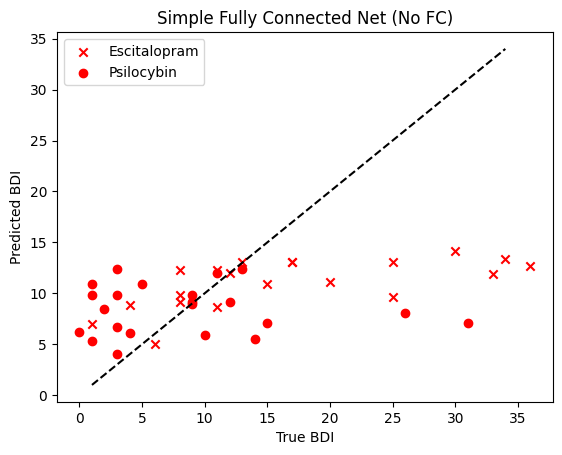

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score, mean_absolute_error

r2_scores = []
mae_scores = []
r_scores = []

l1 = []
l2 = []

for fold in best_set:
    l1.extend([t.item() for t in fold[0]])
    l2.extend([t.item() for t in fold[1]])
    
print(r2_score(l1, l2))
print(pearsonr(l1, l2))
print(mean_absolute_error(l1,l2))

print()

total_true = []
total_pred = []
total_drug = []
total_base = []

for i, (true, pred, base) in enumerate(best_set):
    true = [t.item() for t in true]
    pred = [p.item() for p in pred]
    drug = [d[0].item() for d in base]
    base = [d[1].item() for d in base]
    
    total_true.extend(true)
    total_pred.extend(pred)
    total_drug.extend(drug)
    total_base.extend(base)
    # Calculate R-squared (Pearson correlation coefficient)
    r2 = r2_score(true, pred)
    r2_scores.append(r2)

    r_scores.append(pearsonr(true, pred))
    
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(true, pred)
    mae_scores.append(mae)
    
    for t, p, d in zip(true, pred, drug):
        marker = 'x' if d == -1 else 'o'
        plt.scatter(t, p, color='red', marker=marker)

min_val = min(min(true), min(pred))
max_val = max(max(true), max(pred))
plt.plot([min_val, max_val], [min_val, max_val], 'k--')
        
plt.xlabel('True BDI')
plt.ylabel('Predicted BDI')
plt.title('Simple Fully Connected Net (No FC)')
plt.legend(['Escitalopram', 'Psilocybin'])
plt.savefig('simple_fc_net_no_graph.png', bbox_inches='tight')
plt.show()

# Calculate average R-squared and MAE across all folds
avg_r2 = np.mean(r2_scores)
avg_mae = np.mean(mae_scores)

import csv
        
# Specify the filename for the CSV file
filename = 'simple-fc-net-nofc.csv'

# Create a list of rows with headers
rows = [['true_post_bdi', 'predicted_post_bdi', 'drug (1 for psilo)', 'base_bdi']]
for true, pred, drug, base in zip(total_true, total_pred, total_drug, total_base):
    rows.append([true, pred, drug, base]) 

# Write the rows to the CSV file
with open(filename, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(rows)